In [1]:
import numpy as np
import h5py

In [2]:
def load_OASIS():
     with h5py.File('..\..\Datasets\OASIS_balanced.h5', 'r') as hdf:
        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))
        return trainX, trainY, testX, testY

In [3]:
def load_ADNI():
    with h5py.File('..\..\Datasets\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [4]:
dataset = 'ADfNI'
# read the data which is also normalized.
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(8192, 176, 176) (8192,) (2560, 176, 176) (2560,)


In [5]:
raw_pixels = False #use this to choose between raw pixels and VGG16 features

In [6]:
# make it 3D (for VGG16)
if (raw_pixels == False):
    if dataset == 'ADNI':
        x_train = np.repeat(x_train, 3, axis=3)
        x_test = np.repeat(x_test, 3, axis=3)
    else:
        x_train = np.expand_dims(x_train, axis=-1)
        x_train = np.repeat(x_train, 3, axis=3)
        x_test = np.expand_dims(x_test, axis=-1)
        x_test = np.repeat(x_test, 3, axis=3)
print('x_train shape:', x_train.shape)

x_train shape: (8192, 176, 176, 3)


In [7]:
if (raw_pixels  == False):

    from tensorflow.keras.applications.vgg16 import VGG16
    if dataset == 'ADNI':
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(218, 182, 3))
    else:
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
    # Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in VGG_model.layers:
        layer.trainable = False

    VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [9]:
if (raw_pixels == False):
# Now, let us use features from convolutional network for KNN
    print("extracting VGG16 features")
    feature_extractor=VGG_model.predict(x_train)
    print("reshaping features")
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
    # print(feature_extractor.shape)
    # print(features.shape)

    X_Train = features #This is our X input to Logistic Regression.

    #Send test data through same feature extractor process
    X_test_feature = VGG_model.predict(x_test)
    X_Test = X_test_feature.reshape(X_test_feature.shape[0], -1)
    print(X_Test.shape)
    print(X_Train.shape)

extracting VGG16 features


ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,176,176] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node vgg16/block1_conv2/Relu (defined at C:\Users\noush\AppData\Local\Temp\ipykernel_11148\3759891818.py:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_501]

Function call stack:
predict_function


In [10]:
#BELOW CODE IS FOR USING DIRECT PIXELS.
if (raw_pixels != False):
    print('using raw pixels for classification:')
    print ('old shape',x_train.shape)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
    print('new shape',x_train.shape)
    X_Train = x_train
    X_Test = x_test

using raw pixels for classification:
old shape (8192, 176, 176)
new shape (8192, 30976)


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier object
rf = RandomForestClassifier(n_estimators=100, random_state=42)
parameters = {
                'n_estimators': [10,50,100],
                'criterion': ['gini'],
             }
clf = GridSearchCV(RandomForestClassifier(),param_grid=parameters, cv=3, verbose=3, scoring='accuracy')
clf.fit(x_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...criterion=gini, n_estimators=10;, score=0.773 total time=   6.0s
[CV 2/3] END ...criterion=gini, n_estimators=10;, score=0.776 total time=   6.1s
[CV 3/3] END ...criterion=gini, n_estimators=10;, score=0.786 total time=   6.4s
[CV 1/3] END ...criterion=gini, n_estimators=50;, score=0.836 total time=  25.1s
[CV 2/3] END ...criterion=gini, n_estimators=50;, score=0.832 total time=  21.8s
[CV 3/3] END ...criterion=gini, n_estimators=50;, score=0.851 total time=  21.3s
[CV 1/3] END ..criterion=gini, n_estimators=100;, score=0.847 total time=  42.9s
[CV 2/3] END ..criterion=gini, n_estimators=100;, score=0.846 total time=  43.0s
[CV 3/3] END ..criterion=gini, n_estimators=100;, score=0.867 total time=  42.0s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'n_estimators': [10, 50, 100]},
             scoring='accuracy', verbose=3)

In [12]:
from sklearn import metrics
prediction = clf.predict(X_Train)
print("training accuracy: ",metrics.accuracy_score(prediction, y_train))

training accuracy:  1.0


In [13]:
prediction=clf.predict(X_Test)
print("estimating accuracy")
#Print overall accuracy
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction, labels=[0,1,2,3], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR",np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall",np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))


print("Accuracy = ", metrics.accuracy_score(y_test, prediction))

# use model to predict probability that given y value is 1
y_pred_proba = clf.predict_proba(X_Test)

#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

#print AUC score
print("AUC =",auc)

estimating accuracy
Specificity or TNR 0.9636837086102125
Sensitivity or TPR or Recall 0.8919602711941336
FNR  0.10803972880586643
FPR 0.036316291389787536
Accuracy =  0.891015625
AUC = 0.9798089971162506


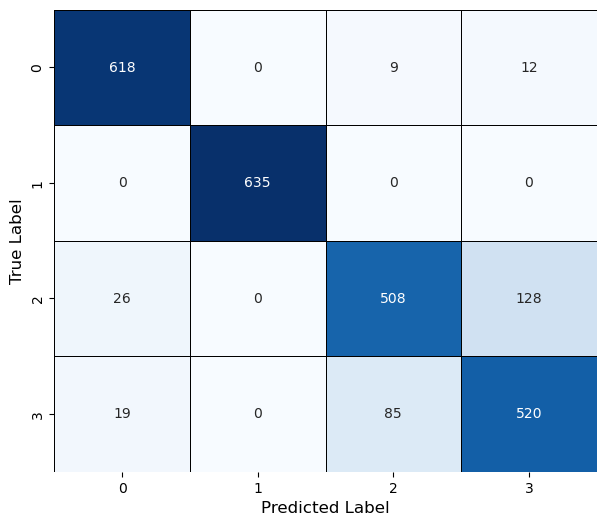

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
plt.savefig("CM-RF-ADNI-RAWPIXELS.pdf")

In [15]:
import pandas as pd
df = pd.DataFrame(clf.cv_results_)
#print(df.columns)
df['learning_rate']
print("best parameters",clf.best_params_)
print("best scores",clf.best_score_)

KeyError: 'learning_rate'